In [1]:
import sys
sys.path.append("D:\\ASGaze")

import os
import os.path as path

import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import import_ipynb
from iris_boundary_detector.data_sources.detection import detection_main
from iris_boundary_detector.inference import inference_main
from setup import ambiguity_removal_main,cal_offsets_main
from gaze_ray_estimator.estimator import tracker,load_files
from mapping.mapping_principle import screen2cam_mm

importing Jupyter notebook from D:\ASGaze\iris_boundary_detector\data_sources\detection.ipynb
importing Jupyter notebook from D:\ASGaze\iris_boundary_detector\inference.ipynb
importing Jupyter notebook from D:\ASGaze\iris_boundary_detector\utils\refinement.ipynb
importing Jupyter notebook from D:\ASGaze\iris_boundary_detector\data_sources\ASGaze_data.ipynb
importing Jupyter notebook from D:\ASGaze\iris_boundary_detector\data_sources\transform.ipynb
importing Jupyter notebook from D:\ASGaze\iris_boundary_detector\graph\losses.ipynb
importing Jupyter notebook from D:\ASGaze\iris_boundary_detector\graph\vgg_unet.ipynb
importing Jupyter notebook from D:\ASGaze\iris_boundary_detector\utils\load_model.ipynb
importing Jupyter notebook from setup.ipynb
importing Jupyter notebook from D:\ASGaze\gaze_ray_estimator\estimator.ipynb
importing Jupyter notebook from D:\ASGaze\gaze_ray_estimator\cone_model.ipynb
importing Jupyter notebook from D:\ASGaze\mapping\mapping_principle.ipynb
importing Jupyte

In [2]:
root_path = "./"
data_path = path.join(root_path,"Database","raw_data")

### Step 1: Detect and crop the eye using Dilb

In [3]:
# There are two types of data, one for gaze tracking ("tracking"), and the other one for mapping ("corner_1", "corner_2", "corner_3", "corner_4")
detection_list = ["tracking","corner_1","corner_2","corner_3","corner_4"]

detection_main(data_path,detection_list,rotate=True)

tracking
Extracting frames from ./Database\raw_data\tracking to ./Database\raw_data\tracking\frame/ ...
Successfully extract 588 frames.
Total frames 588. Success rate: 1.0
corner_1
Extracting frames from ./Database\raw_data\corner_1 to ./Database\raw_data\corner_1\frame/ ...
Successfully extract 166 frames.
Total frames 166. Success rate: 1.0
corner_2
Extracting frames from ./Database\raw_data\corner_2 to ./Database\raw_data\corner_2\frame/ ...
Successfully extract 170 frames.
Total frames 170. Success rate: 1.0
corner_3
Extracting frames from ./Database\raw_data\corner_3 to ./Database\raw_data\corner_3\frame/ ...
Successfully extract 208 frames.
Total frames 208. Success rate: 1.0
corner_4
Extracting frames from ./Database\raw_data\corner_4 to ./Database\raw_data\corner_4\frame/ ...
Successfully extract 187 frames.
Total frames 187. Success rate: 1.0
Done


### Step 2: Iris boundary detector

In [4]:
gaze_inference = "./iris_boundary_detector/configs/gaze_inference.json"
test_name_list = ["tracking","corner_1","corner_2","corner_3","corner_4"]
for test_name in test_name_list:
    print(test_name) 
    inference_main(gaze_inference,test_name,data_flag=0,video=True)
print('DONE')

tracking
runs_dir D:\ASGaze\Database\raw_data\tracking\0207-1231
load checkpoingts from D:\ASGaze\Database\output\CMonitor-0207-1231
datapath D:\ASGaze\Database\raw_data\tracking\crop\left
Load 588 samples of tracking/crop Dataset left split from D:/ASGaze/Database/raw_data\tracking/crop\left
datapath D:\ASGaze\Database\raw_data\tracking\crop\right
Load 588 samples of tracking/crop Dataset right split from D:/ASGaze/Database/raw_data\tracking/crop\right


C:\Users\jncao2\Anaconda3\envs\py3.7\lib\site-packages\torch\nn\functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\jncao2\Anaconda3\envs\py3.7\lib\site-packages\torch\nn\functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Left eye inference finish
Right eye inference finish
corner_1
runs_dir D:\ASGaze\Database\raw_data\corner_1\0207-1231
load checkpoingts from D:\ASGaze\Database\output\CMonitor-0207-1231
datapath D:\ASGaze\Database\raw_data\corner_1\crop\left
Load 166 samples of corner_1/crop Dataset left split from D:/ASGaze/Database/raw_data\corner_1/crop\left
datapath D:\ASGaze\Database\raw_data\corner_1\crop\right
Load 166 samples of corner_1/crop Dataset right split from D:/ASGaze/Database/raw_data\corner_1/crop\right
Left eye inference finish
Right eye inference finish
corner_2
runs_dir D:\ASGaze\Database\raw_data\corner_2\0207-1231
load checkpoingts from D:\ASGaze\Database\output\CMonitor-0207-1231
datapath D:\ASGaze\Database\raw_data\corner_2\crop\left
Load 170 samples of corner_2/crop Dataset left split from D:/ASGaze/Database/raw_data\corner_2/crop\left
datapath D:\ASGaze\Database\raw_data\corner_2\crop\right
Load 170 samples of corner_2/crop Dataset right split from D:/ASGaze/Database/raw_dat

### Step 3: Remove ambiguity and calculate the offsets between CCS and TCS

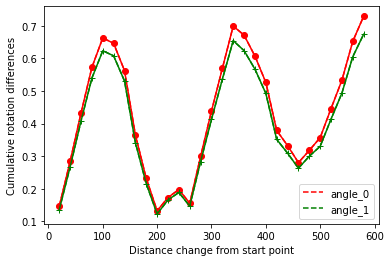

True sequence is: 1
offsets [294.44782468 309.87838956]


In [5]:
test_name = "tracking"
model_id = "0207-1231"
iris_radius = 6
true_seq = ambiguity_removal_main(data_path,test_name,model_id,iris_radius)

test_name_list = ["corner_1","corner_2","corner_3","corner_4"]
thresholds = [3,3,7,7] # Set threshold to determine the minimum number of eye frames to use when the user looks at each corner
offsets = cal_offsets_main(data_path,test_name_list,model_id,iris_radius,true_seq,thresholds)

### Step 4: Gaze ray estimator

In [6]:
window_size = 2
is_video = True

print(test_name)
p_model,frame_files,ellipse_files_l,ellipse_files_r,crop_info,gaze_label_mm,camera_matrix_inv = load_files(data_path,test_name,model_id)
rotated_rect_l,rotated_rect_r,gaze_origin_l,gaze_origin_r,screen_left,screen_right = tracker(p_model,frame_files,ellipse_files_l,ellipse_files_r,crop_info,gaze_label_mm,camera_matrix_inv,iris_radius,true_seq,offsets,window_size,is_video)

tracking
Gaze Ray Estimator Done
-------------Error Calculation Done----------

x_axis_best:0.04746823043750226 mm, index:215

x_axis_worst:94.48521630590193 mm, index:238

y_axis_best:0.10460969940825748 mm, index:465

y_axis_worst:54.444490105229875 mm, index:449

overall error:17.903518730320208 mm

overall error after moving average filter:17.266070432837385 mm



### Step 5: Generate demo video (optional)

In [7]:
demo = cv2.VideoWriter(path.join(p_model, "3d_trace.avi"), cv2.VideoWriter_fourcc(*"XVID"), 30, (2160,3840))
for i in range(0,len(frame_files)):
    #-------------------Visulization----------------------
    full_frame = cv2.imread(frame_files[i])

    #----via ellipse-----
    cv2.ellipse(full_frame, rotated_rect_l[i],(255, 255, 255), 2)
    cv2.ellipse(full_frame, rotated_rect_r[i],(255, 255, 255), 2)
    #----via circle-----
    center_l = (int(rotated_rect_l[i][0][0]),int(rotated_rect_l[i][0][1]))
    cv2.circle(full_frame,center_l,20,(255, 255, 255),-1)

    center_r = (int(rotated_rect_r[i][0][0]),int(rotated_rect_r[i][0][1]))
    cv2.circle(full_frame,center_r,20,(255, 255, 255),-1)
    #----via polylines-----
    gaze_l = screen2cam_mm(screen_left[i],offsets[0],offsets[1]) - gaze_origin_l[i][:3]
    gaze_stick_l = gaze_l/np.linalg.norm(gaze_l)*500
    cv2.polylines(full_frame,np.array([[center_l,center_l+gaze_stick_l[:2]]],dtype=int),True, (255,255,0),8)

    gaze_r = screen2cam_mm(screen_right[i],offsets[0],offsets[1]) - gaze_origin_r[i][:3]
    gaze_stick_r = gaze_r/np.linalg.norm(gaze_r)*500
    cv2.polylines(full_frame,np.array([[center_r,center_r+gaze_stick_r[:2]]],dtype=int),True, (255,255,0),8)
    
    demo.write(full_frame)
demo.release()
print("Done")

Done


In [8]:
# Reference from https://towardsdatascience.com/matplotlib-animations-in-jupyter-notebook-4422e4f0e389
plt.ioff()

print(test_name)
screen = 0.5*(screen_left+screen_right)

# Create a figure with an axes
fig, ax = plt.subplots(figsize = (26.68,15))
ax.set_xlim(left=0, right=527)
ax.set_ylim(bottom=296, top=0)

ax.set_xlabel('width',fontdict={'size':40})
ax.set_ylabel('height',fontdict={'size':40})
plt.tick_params(labelsize=40)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]

ax.xaxis.tick_top() 

# Create a point in the axes
point_screen, = ax.plot(0,1, ms = 40,color="blue", marker="o")
point_label, = ax.plot(0,1, ms = 40,color="red",marker="o")
ax.legend((point_screen, point_label), ('Estimated Gaze Point', 'Ground Truth'), loc='best', fontsize = 40, shadow=True)

# Updating function, to be repeatedly called by the animationb
def update(idx):
    # Obtain point coordinates 
    x_screen,y_screen = screen[idx]
    x_label,y_label = gaze_label_mm[idx]
    # Set point's coordinates
    point_screen.set_data([x_screen],[y_screen])
    point_label.set_data([x_label],[y_label])
    return point_screen,point_label

anim = FuncAnimation(fig, update, repeat=False, frames=np.arange(len(gaze_label_mm)), interval=1/30.0*1000)
anim.save(path.join(p_model,"2d_trace.mp4"))

plt.close()
print("Done")

tracking
Done
